<a href="https://colab.research.google.com/github/ZahraShahlaie/Crack-detection/blob/main/Crack_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

install kaggle




In [1]:
!pip install kaggle

To download files from Google Drive using Python

In [2]:
!pip install gdown

import libraries

In [3]:
import os
import cv2
import time
import gdown
import keras
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm
from pathlib import Path

from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.image import imread
from tensorflow.keras import Model,layers
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import VGG16, EfficientNetB7, NASNetMobile, NASNetLarge
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.inception_v3 import InceptionV3

read kaggle.json file

In [4]:
!chmod 600  /content/kaggle.json

chmod: cannot access '/content/kaggle.json': No such file or directory


In [5]:
import os
os.environ['KAGGLE_USERNAME']= 'zsh1999'
os.environ['KAGGLE_KEY']= 'bc278e36364cd8bd89101e311476fc1d'

download dataset color-classification

In [6]:
!kaggle datasets download -d arunrk7/surface-crack-detection

Dataset URL: https://www.kaggle.com/datasets/arunrk7/surface-crack-detection
License(s): copyright-authors
 99% 230M/233M [00:14<00:00, 19.7MB/s]
100% 233M/233M [00:14<00:00, 16.8MB/s]


Extract the downloaded file

In [7]:
import zipfile

# Replace 'path_to_zip_file.zip' with the actual path to your downloaded ZIP file
zip_file_path = '/content/surface-crack-detection.zip'

# Replace 'extracted_folder' with the desired name for the extracted folder
extracted_folder = '/content'

# Create the target directory if it doesn't exist
import os
os.makedirs(extracted_folder, exist_ok=True)

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

print("ZIP file extracted successfully.")


ZIP file extracted successfully.


#---------------------------------------------------------


## Load Dataset

In [8]:
def load_and_display_images(folder, num_images=9):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
        if len(images) >= num_images:
            break

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.suptitle("Sample Images", fontsize=16)
    plt.axis("off")


    for img, ax in zip(images, axes.ravel()):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis("off")


    plt.show()

**Apply night and low light mode simulation to dataset photos
, just to see the photos**


In [9]:
def load_and_display_low_light_images(folder, num_images=9):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
        if len(images) >= num_images:
            break

    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    fig.suptitle("Sample simulated night Images", fontsize=16)
    plt.axis("off")

    for img, ax in zip(images, axes.ravel()):

        # Convert the image to LAB color space
        lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

        # Separate L, A and B channels
        l_channel, a_channel, b_channel = cv2.split(lab_image)

        # Setting channel L (brightness_factor) for light control
        l_channel = cv2.convertScaleAbs(l_channel, alpha=0.5)

        # Set A and B channels contrast_factor to control the color difference
        a_channel = cv2.convertScaleAbs(a_channel, alpha=1 )
        b_channel = cv2.convertScaleAbs(b_channel, alpha=1 )

        # Merge LAB channels again to make new image
        simulated_night_image = cv2.merge((l_channel, a_channel, b_channel))

        # Convert merged image to BGR color space
        simulated_night_image = cv2.cvtColor(simulated_night_image, cv2.COLOR_LAB2BGR)
        ax.imshow(simulated_night_image)
        ax.axis("off")


    plt.show()


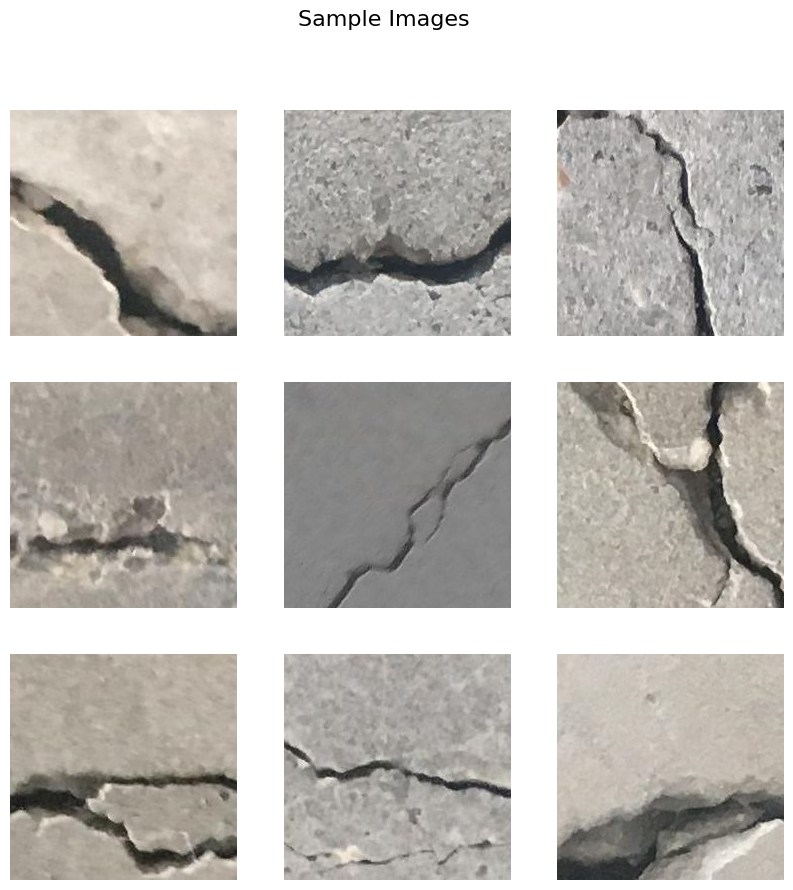

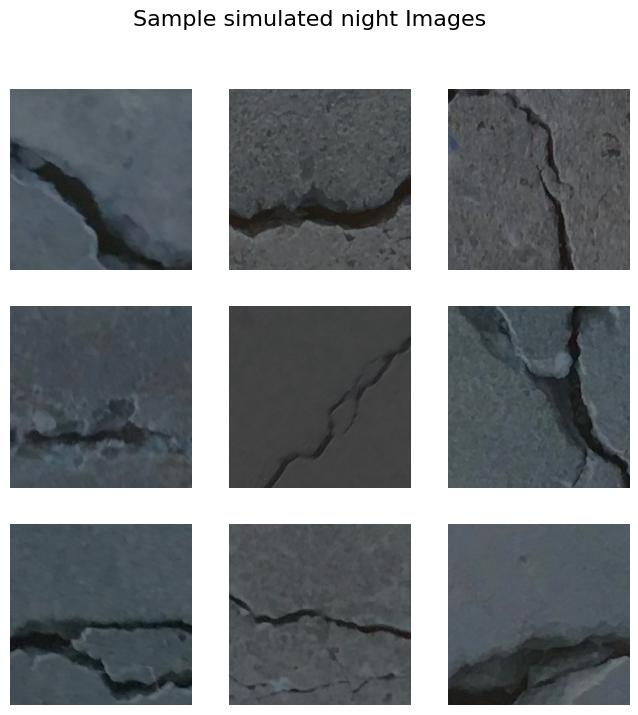

In [10]:
image_folder = "/content/Positive"
load_and_display_images(image_folder, num_images=9)
load_and_display_low_light_images(image_folder, num_images=9)

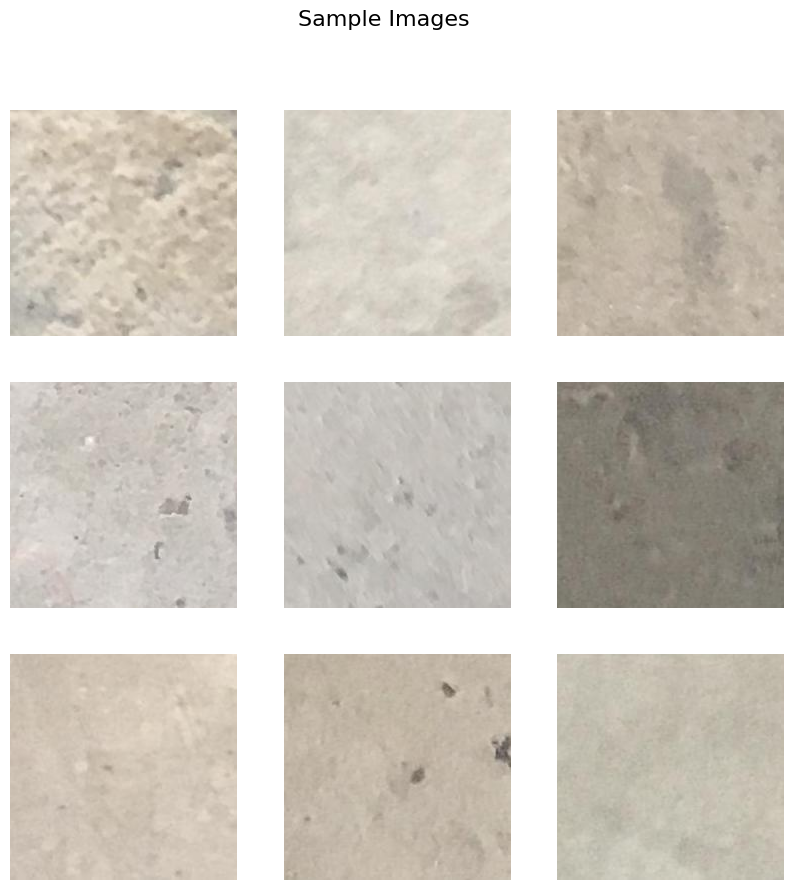

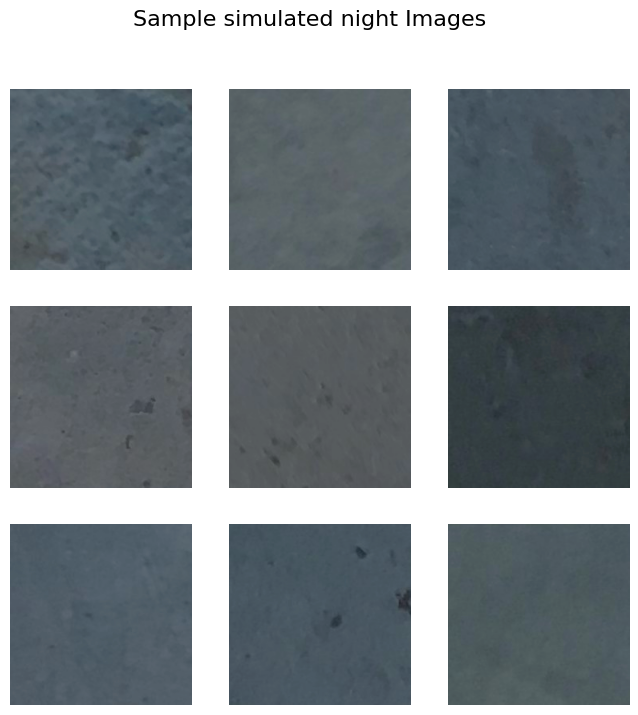

In [11]:
image_folder = "/content/Negative"
load_and_display_images(image_folder, num_images=9)
load_and_display_low_light_images(image_folder, num_images=9)

#  **Image Processing for To simulate the night mode and low light to data photos**

In [12]:
# Defining new folder paths
positive_change_light_dir = Path('/content/Positive_change_light')
negative_change_light_dir = Path('/content/Negative_change_light')

# Create the new folders
os.makedirs(positive_change_light_dir, exist_ok=True)
os.makedirs(negative_change_light_dir, exist_ok=True)

def change_image_brightness(input_filename, output_filename):
    img = cv2.imread(input_filename)

# Convert the image to LAB color space
    lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

# Separate L, A and B channels
    l_channel, a_channel, b_channel = cv2.split(lab_image)

# Setting channel L (brightness_factor) for light control
    l_channel = cv2.convertScaleAbs(l_channel, alpha=0.5)

# Set A and B channels contrast_factor to control the color difference
    a_channel = cv2.convertScaleAbs(a_channel, alpha=1 )
    b_channel = cv2.convertScaleAbs(b_channel, alpha=1 )

 # Merge LAB channels again to make new image
    simulated_night_image = cv2.merge((l_channel, a_channel, b_channel))

# Convert merged image to BGR color space
    simulated_night_image = cv2.cvtColor(simulated_night_image, cv2.COLOR_LAB2BGR)

# Save the image in the desired path
    cv2.imwrite(output_filename, simulated_night_image)


In [13]:
#Calling a function to adjust the brightness of positive images
positive_dir = "/content/Positive"
for filename in tqdm(os.listdir(positive_dir)):
    input_path = os.path.join(positive_dir, filename)
    output_path = os.path.join(positive_change_light_dir, filename)
    change_image_brightness(input_path, output_path)



100%|██████████| 20000/20000 [01:18<00:00, 256.30it/s]


In [14]:
# Calling a function to adjust the brightness of negative images
negative_dir = "/content/Negative"
for filename in tqdm(os.listdir(negative_dir)):
    input_path = os.path.join(negative_dir, filename)
    output_path = os.path.join(negative_change_light_dir, filename)
    change_image_brightness(input_path, output_path)

100%|██████████| 20000/20000 [01:07<00:00, 297.92it/s]


**See some samples of data available after image process on new path**

In [15]:
def load_and_display_images_from_new_folder(folder, num_images=9):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
        if len(images) >= num_images:
            break

    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    fig.suptitle("Sample Images", fontsize=16)

    for img, ax in zip(images, axes.ravel()):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(f"Shape: {img.shape}")

    plt.show()

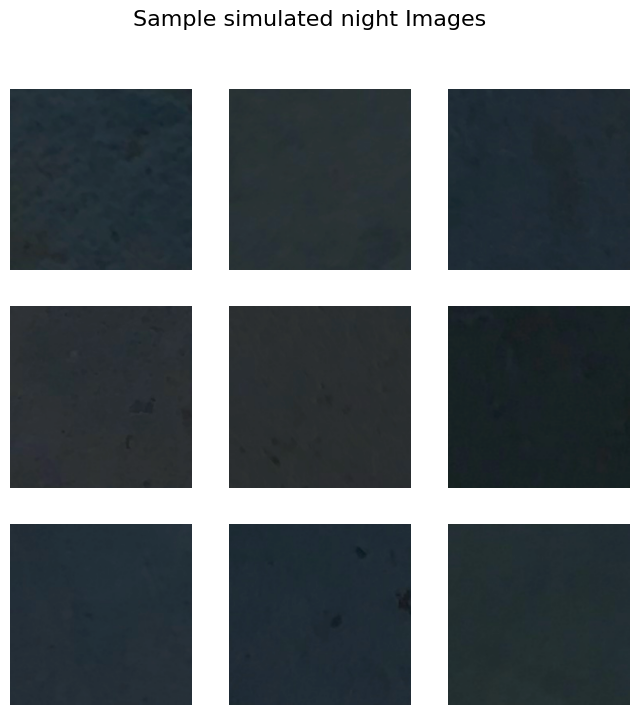

In [16]:
load_and_display_low_light_images(negative_change_light_dir, num_images=9)


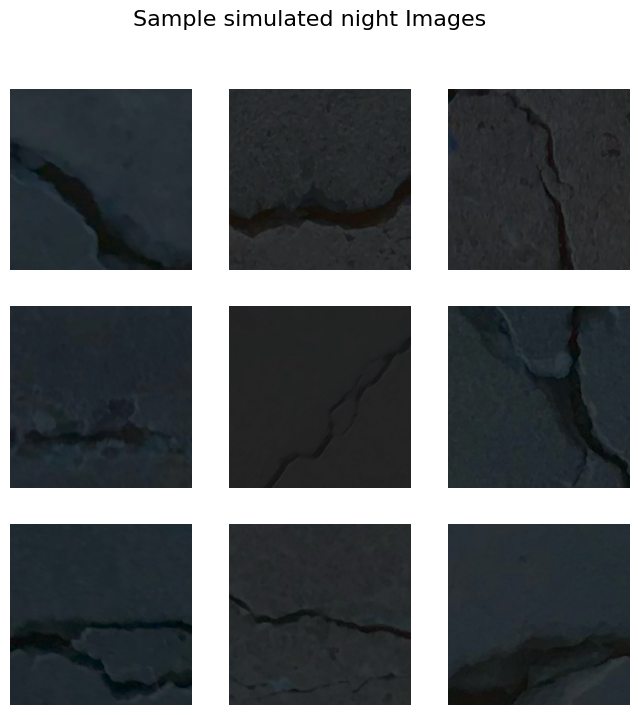

In [17]:
load_and_display_low_light_images(positive_change_light_dir, num_images=9)


# unzooming positive crack detection 681*681 size


**Concatenate images of the same size vertically and horizontally:  images can be combined using both cv2.hconcat() and cv2.vconcat() in tile form using a 2D list.**

In [18]:

# Defining new folder paths
Positive_unzoom_images_dir = Path('/content/Positive_unzoom_images')

# Create the new folders
os.makedirs(Positive_unzoom_images_dir, exist_ok=True)

def creat_unzoom_positive_images():

    new_img=[]
    image_path=[]
    combined_image = None

    #Path definition
    negative_dir = Path('/content/Negative')
    positive_dir = Path('/content/Positive')

    for filename in tqdm(os.listdir(positive_dir)):
        #save path of positive image
        image_path_positive = str(positive_dir / filename)

        #choose 8 negative image randomlly
        neg_images = random.sample(os.listdir(negative_dir),8)

        #save path of negative images
        image_paths_negative = [str(negative_dir / image_name) for image_name in neg_images]

        #sum of image_path_positive and image_paths_negative
        image_paths = [image_path_positive] + image_paths_negative

       # Shuffle the list randomly :couse of i want change position of positive image
        random.shuffle(image_paths)

        # Reshape to 3x3
        image_paths = np.array(image_paths).reshape(3, 3)


        #I did the above codes with the path so now I read the path to prepare to show

        # Create a matrix to hold the images
        images = []
        #Scroll in loops for make matrix images
        for row in image_paths:
            row_images = []
            for image_path in row:
                img = cv2.imread(image_path)
                row_images.append(img)
            images.append(row_images)


       # Combine the images in the matrix into one image
        combined_image = cv2.vconcat([cv2.hconcat(images_row) for images_row in images])

       # Save the image in the new path
        path_unzoom_images_dir = os.path.join(Positive_unzoom_images_dir, filename)
        cv2.imwrite(path_unzoom_images_dir, combined_image)




In [19]:
creat_unzoom_positive_images()

100%|██████████| 20000/20000 [09:27<00:00, 35.22it/s]


**show some samples from unzoom_positive_images**




19595.jpg


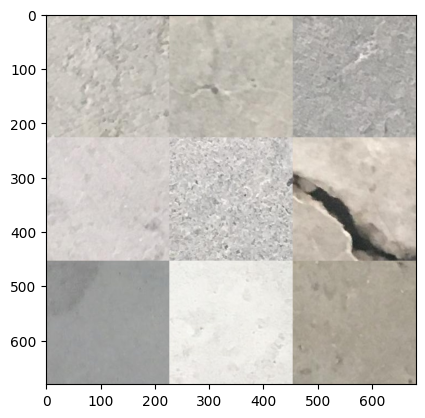

12311_1.jpg


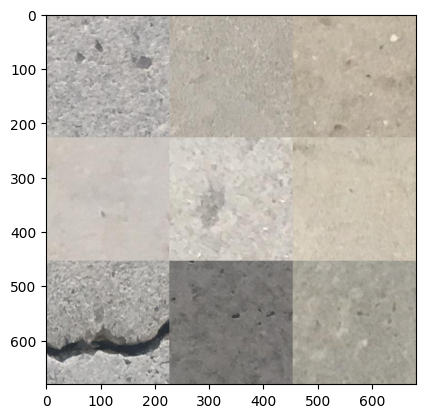

19295_1.jpg


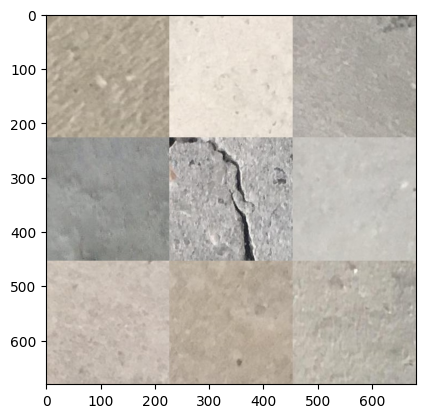

04730.jpg


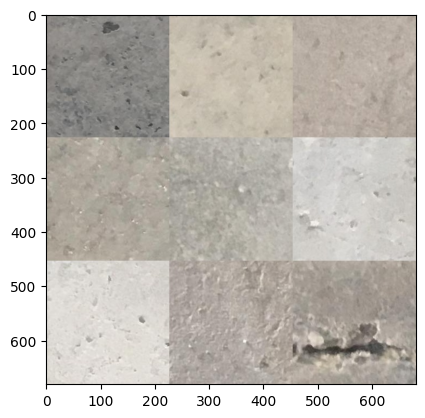

05466.jpg


In [20]:

images = []
for filename in os.listdir(Positive_unzoom_images_dir):
    print(filename)
    path = os.path.join(Positive_unzoom_images_dir,filename)
    img =cv2.imread(path)

   # limiting on implementation

    if img is not None:
        images.append(img)
    if len(images) >= 5:
        break

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [21]:


# Defining new folder paths
Negative_unzoom_images_dir = Path('/content/Negative_unzoom_images')

# Create the new folders
os.makedirs(Negative_unzoom_images_dir, exist_ok=True)

def creat_unzoom_negative_images():

    new_img=[]
    image_path=[]
    combined_image = None

    #Path definition
    negative_dir = Path('/content/Negative')

    for filename in tqdm(os.listdir(negative_dir)):
        #save path of negative image
        image_path_negative_one = str(negative_dir / filename)

        #choose 8 negative image randomlly
        neg_images = random.sample(os.listdir(negative_dir),8)

        #save path of negative images
        image_paths_negative = [str(negative_dir / image_name) for image_name in neg_images]

        #sum of image_path_negative_one and image_paths_negative
        image_paths = [image_path_negative_one] + image_paths_negative

       # Shuffle the list randomly :couse of i want change position of positive image
        random.shuffle(image_paths)

        # Reshape to 3x3
        image_paths = np.array(image_paths).reshape(3, 3)


        #i do above codes with path so now i read path for prepare to show

        # Create a matrix to hold the images
        images = []
        #Scroll in loops for make matrix images
        for row in image_paths:
            row_images = []
            for image_path in row:
                img = cv2.imread(image_path)
                row_images.append(img)
            images.append(row_images)


       # Combine the images in the matrix into one image
        combined_image = cv2.vconcat([cv2.hconcat(images_row) for images_row in images])

       # Save the image in the new path
        path_unzoom_images_dir = os.path.join(Negative_unzoom_images_dir, filename)
        cv2.imwrite(path_unzoom_images_dir, combined_image)


In [22]:
creat_unzoom_negative_images()

100%|██████████| 20000/20000 [09:30<00:00, 35.06it/s]


**show some samples from unzoom_negative_images**


19595.jpg


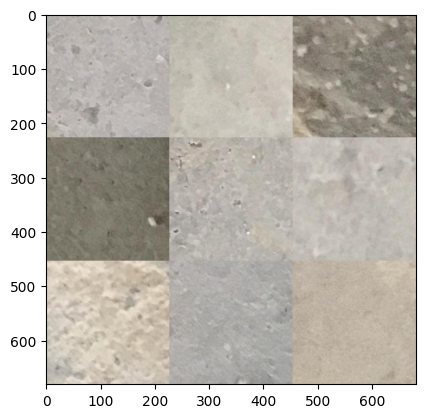

18106.jpg


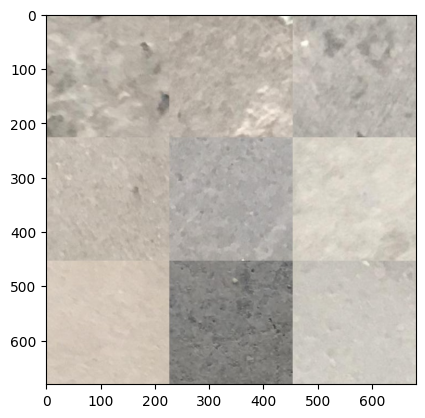

04730.jpg


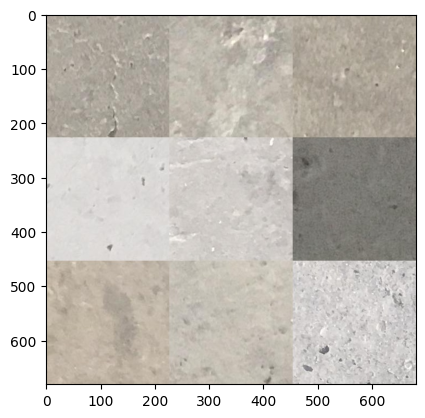

05466.jpg


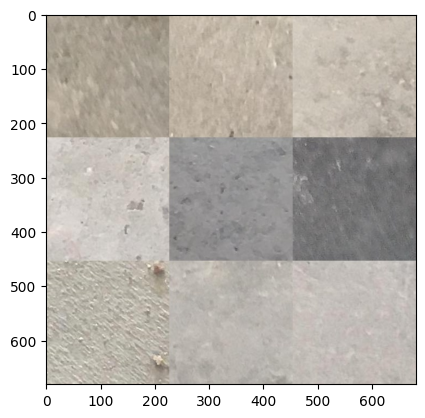

02688.jpg


In [23]:
images = []
for filename in os.listdir(Negative_unzoom_images_dir):
    print(filename)
    path = os.path.join(Negative_unzoom_images_dir,filename)
    img =cv2.imread(path)

   # limiting on implementation

    if img is not None:
        images.append(img)
    if len(images) >= 5:
        break

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

# unzooming positive crack detection 5*5


In [24]:

# Defining new folder paths
Positive_unzoom_biggerImages_dir = Path('/content/Positive_unzoom_images_bigger')

# Create the new folders
os.makedirs(Positive_unzoom_biggerImages_dir, exist_ok=True)

def creat_unzoom_positive_biggerImages():

    new_img=[]
    image_path=[]
    combined_image = None

    #Path definition
    negative_dir = Path('/content/Negative')
    positive_dir = Path('/content/Positive')

    for filename in tqdm(os.listdir(positive_dir)):
        #save path of positive image
        image_path_positive = str(positive_dir / filename)

        #choose 8 negative image randomlly
        neg_images = random.sample(os.listdir(negative_dir),24)

        #save path of negative images
        image_paths_negative = [str(negative_dir / image_name) for image_name in neg_images]

        #sum of image_path_positive and image_paths_negative
        image_paths = [image_path_positive] + image_paths_negative

       # Shuffle the list randomly :couse of i want change position of positive image
        random.shuffle(image_paths)

        # Reshape to 5*5
        image_paths = np.array(image_paths).reshape(5, 5)


        #i do above codes with path so now i read path for prepare to show

        # Create a matrix to hold the images
        images = []
        #Scroll in loops for make matrix images
        for row in image_paths:
            row_images = []
            for image_path in row:
                img = cv2.imread(image_path)
                row_images.append(img)
            images.append(row_images)


       # Combine the images in the matrix into one image
        combined_image = cv2.vconcat([cv2.hconcat(images_row) for images_row in images])

       # Save the image in the new path
        path_unzoom_images_dir = os.path.join(Positive_unzoom_biggerImages_dir, filename)
        cv2.imwrite(path_unzoom_images_dir, combined_image)




In [25]:
creat_unzoom_positive_biggerImages()

100%|██████████| 20000/20000 [20:14<00:00, 16.46it/s]


**show some samples from unzoom_positive_biggerImages**





19595.jpg


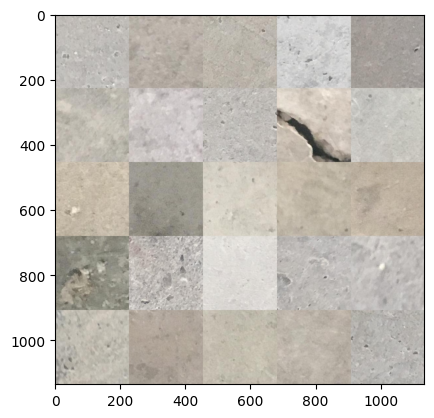

12311_1.jpg


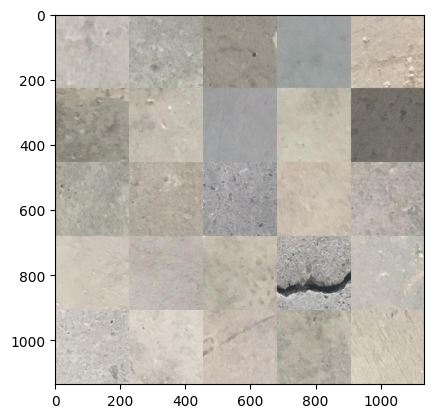

19295_1.jpg


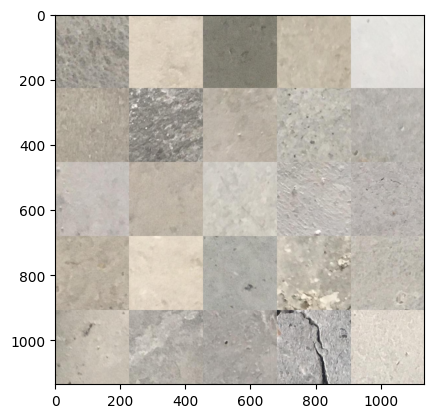

04730.jpg


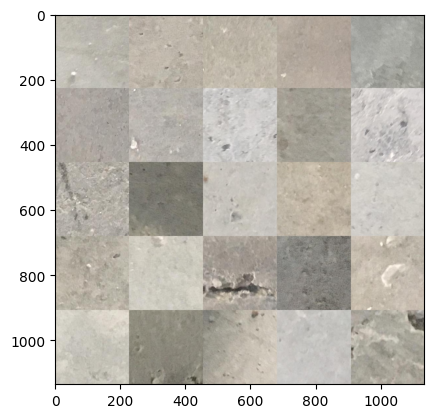

05466.jpg


In [26]:

images = []
for filename in os.listdir(Positive_unzoom_biggerImages_dir):
    print(filename)
    path = os.path.join(Positive_unzoom_biggerImages_dir,filename)
    img =cv2.imread(path)

   # limiting on implementation

    if img is not None:
        images.append(img)
    if len(images) >= 5:
        break

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [27]:

# Defining new folder paths
Negative_unzoom_biggerImages_dir = Path('/content/Negative_unzoom_images')

# Create the new folders
os.makedirs(Negative_unzoom_biggerImages_dir, exist_ok=True)

def creat_unzoom_negative_biggerImages():

    new_img=[]
    image_path=[]
    combined_image = None

    #Path definition
    negative_dir = Path('/content/Negative')

    for filename in tqdm(os.listdir(negative_dir)):
        #save path of negative image
        image_path_negative_one = str(negative_dir / filename)

        #choose 8 negative image randomlly
        neg_images = random.sample(os.listdir(negative_dir),24)

        #save path of negative images
        image_paths_negative = [str(negative_dir / image_name) for image_name in neg_images]

        #sum of image_path_negative_one and image_paths_negative
        image_paths = [image_path_negative_one] + image_paths_negative

       # Shuffle the list randomly :couse of i want change position of positive image
        random.shuffle(image_paths)

        # Reshape to 5*5
        image_paths = np.array(image_paths).reshape(5, 5)


        #i do above codes with path so now i read path for prepare to show

        # Create a matrix to hold the images
        images = []
        #Scroll in loops for make matrix images
        for row in image_paths:
            row_images = []
            for image_path in row:
                img = cv2.imread(image_path)
                row_images.append(img)
            images.append(row_images)


       # Combine the images in the matrix into one image
        combined_image = cv2.vconcat([cv2.hconcat(images_row) for images_row in images])

       # Save the image in the new path
        path_unzoom_images_dir = os.path.join(Negative_unzoom_biggerImages_dir, filename)
        cv2.imwrite(path_unzoom_images_dir, combined_image)


In [28]:
creat_unzoom_negative_biggerImages()

100%|██████████| 20000/20000 [20:23<00:00, 16.35it/s]


**show some samples from unzoom_negative_biggerImages**


19595.jpg


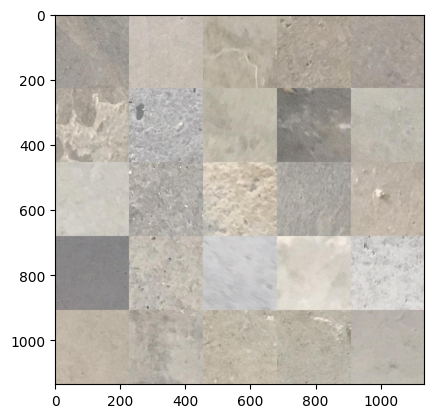

18106.jpg


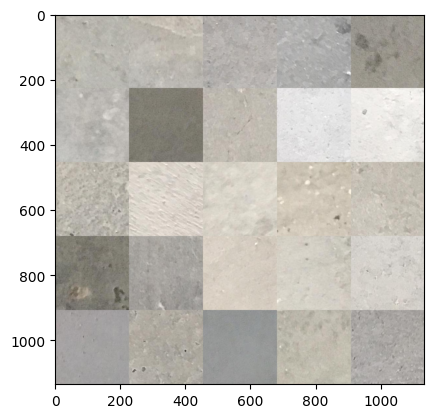

04730.jpg


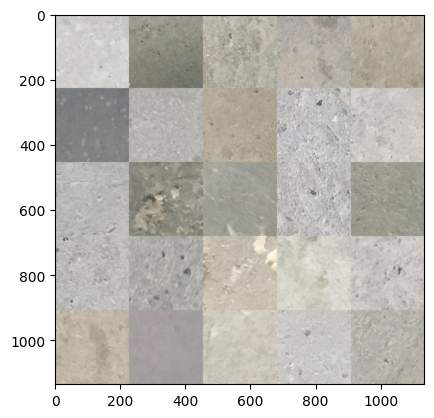

05466.jpg


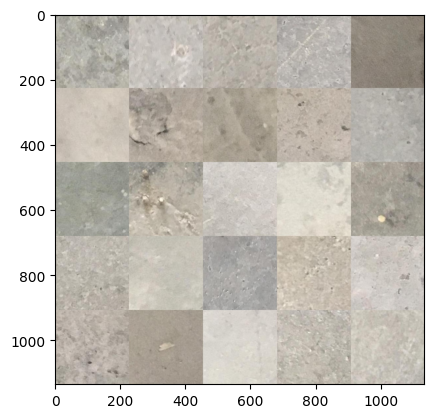

02688.jpg


In [29]:
images = []
for filename in os.listdir(Negative_unzoom_biggerImages_dir):
    print(filename)
    path = os.path.join(Negative_unzoom_biggerImages_dir,filename)
    img =cv2.imread(path)

   # limiting on implementation

    if img is not None:
        images.append(img)
    if len(images) >= 5:
        break

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

# Download the texture images from Google Drive

In [30]:
# URL of the Google Drive folder
url = 'https://drive.google.com/drive/folders/1HLM0H7NKj04uoU6Wxgludw4rDhrN1W3s'

# Change the folder ID to the correct format for gdown
folder_id = url.split('/')[-1].split('?')[0]
download_url = f'https://drive.google.com/drive/folders/{folder_id}'

# Download the folder
gdown.download_folder(download_url, quiet=False)

Retrieving folder contents


Processing file 14OqVP7ZtSNnxbsVNNJ75il1CV-gAu0Oc 1.jpg
Processing file 1b4thzXSp3TqmtLSyEDsQUehEmP9Glcs3 2.jpg
Processing file 16-levI81UTlqIaip_buSHkmq3A_Y12jR 3.jpg


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=14OqVP7ZtSNnxbsVNNJ75il1CV-gAu0Oc
To: /content/Crack detection/1.jpg
100%|██████████| 258k/258k [00:00<00:00, 77.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1b4thzXSp3TqmtLSyEDsQUehEmP9Glcs3
To: /content/Crack detection/2.jpg
100%|██████████| 237k/237k [00:00<00:00, 62.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=16-levI81UTlqIaip_buSHkmq3A_Y12jR
To: /content/Crack detection/3.jpg
100%|██████████| 120k/120k [00:00<00:00, 58.7MB/s]
Download completed


['/content/Crack detection/1.jpg',
 '/content/Crack detection/2.jpg',
 '/content/Crack detection/3.jpg']

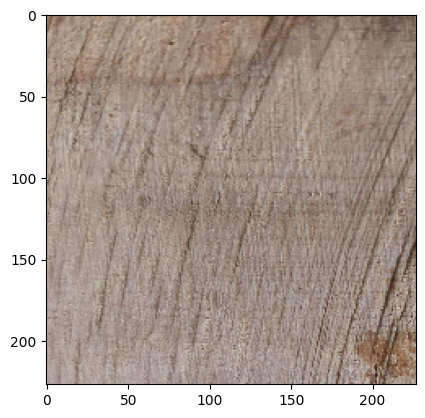

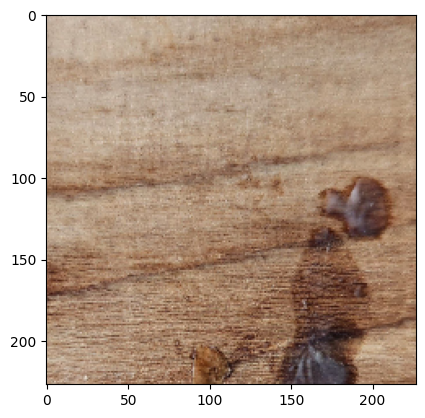

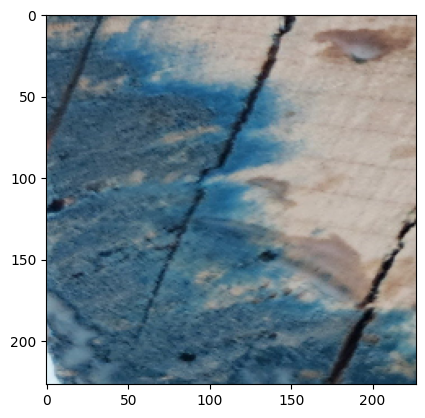

In [31]:
# Defining new folder paths
texture_images_dir = Path('/content/texture_images')

# Create the new folders
os.makedirs(texture_images_dir, exist_ok=True)

#path of images
path_1 = "/content/Crack detection/1.jpg"
path_2 = "/content/Crack detection/2.jpg"
path_3 = "/content/Crack detection/3.jpg"


#read images that choose for texture
image_1 = cv2.imread(path_1)
image_2 = cv2.imread(path_2)
image_3 = cv2.imread(path_3)

#resize images
img_size = (227,227)

img1_resized = cv2.resize(image_1, img_size)
img2_resized = cv2.resize(image_2, img_size)
img3_resized = cv2.resize(image_3, img_size)


#shows images
plt.imshow(img1_resized[:, :, ::-1])
plt.show()


plt.imshow(img2_resized[:, :, ::-1])
plt.show()


plt.imshow(img3_resized[:, :, ::-1])
plt.show()



combine texture images with images in "/content/Negative" path

In [32]:
negative_dir = "/content/Negative"


In [33]:
for filename in tqdm(os.listdir(negative_dir)):
    path = os.path.join(negative_dir,filename)
    img =cv2.imread(path)


    combin_img_1 = cv2.addWeighted(img, 0.90, img1_resized, 0.10 , 0)
    combin_img_2 = cv2.addWeighted(img, 0.90, img2_resized, 0.10 , 0)
    combin_img_3 = cv2.addWeighted(img, 0.90, img3_resized, 0.10 , 0)

    save_path = os.path.join(texture_images_dir, filename)

    # Save the image in the desired path
    cv2.imwrite(save_path, combin_img_1)
    cv2.imwrite(save_path, combin_img_2)
    cv2.imwrite(save_path, combin_img_3)



100%|██████████| 20000/20000 [01:51<00:00, 178.91it/s]


**show some samples from texture_images**




In [ ]:

images = []
for filename in os.listdir(texture_images_dir):
    print(filename)
    path = os.path.join(texture_images_dir,filename)
    img =cv2.imread(path)

   # limiting on implementation

    if img is not None:
        images.append(img)
    if len(images) >= 10:
        break

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

#---------------------------------------------


In [ ]:
positive_dir = Path('/content/Positive')
negative_dir = Path('/content/Negative')

In [ ]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [37]:
positive_df = generate_df(Positive_unzoom_biggerImages_dir, label="POSITIVE")
negative_df = generate_df(Negative_unzoom_biggerImages_dir, label="NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df


Filepath     Label
0      /content/Positive_unzoom_images_bigger/12463_1...  POSITIVE
1       /content/Positive_unzoom_images_bigger/06035.jpg  POSITIVE
2       /content/Positive_unzoom_images_bigger/03760.jpg  POSITIVE
3              /content/Negative_unzoom_images/04573.jpg  NEGATIVE
4      /content/Positive_unzoom_images_bigger/16131_1...  POSITIVE
...                                                  ...       ...
39995  /content/Positive_unzoom_images_bigger/12339_1...  POSITIVE
39996          /content/Negative_unzoom_images/16572.jpg  NEGATIVE
39997  /content/Positive_unzoom_images_bigger/10513_1...  POSITIVE
39998  /content/Positive_unzoom_images_bigger/17037_1...  POSITIVE
39999          /content/Negative_unzoom_images/01006.jpg  NEGATIVE

[40000 rows x 2 columns]

Filepath     Label
0      /content/Positive_unzoom_images_bigger/12463_1...  POSITIVE
1       /content/Positive_unzoom_images_bigger/06035.jpg  POSITIVE
2       /content/Positive_unzoom_images_bigger/03760.jpg  POSITIVE
3              /content/Negative_unzoom_images/04573.jpg  NEGATIVE
4      /content/Positive_unzoom_images_bigger/16131_1...  POSITIVE
...                                                  ...       ...
39995  /content/Positive_unzoom_images_bigger/12339_1...  POSITIVE
39996          /content/Negative_unzoom_images/16572.jpg  NEGATIVE
39997  /content/Positive_unzoom_images_bigger/10513_1...  POSITIVE
39998  /content/Positive_unzoom_images_bigger/17037_1...  POSITIVE
39999          /content/Negative_unzoom_images/01006.jpg  NEGATIVE

[40000 rows x 2 columns]

## Pretrained Model

### 1. VGG16

https://www.kaggle.com/keras/vgg16

The input to conv1 layer is of fixed size 224 x 224 RGB image. The image is passed through a stack of convolutional (conv.) layers, where the filters were used with a very small receptive field: 3×3 (which is the smallest size to capture the notion of left/right, up/down, center). In one of the configurations, it also utilizes 1×1 convolution filters, which can be seen as a linear transformation of the input channels (followed by non-linearity). The convolution stride is fixed to 1 pixel; the spatial padding of conv. layer input is such that the spatial resolution is preserved after convolution, i.e. the padding is 1-pixel for 3×3 conv. layers. Spatial pooling is carried out by five max-pooling layers, which follow some of the conv. layers (not all the conv. layers are followed by max-pooling). Max-pooling is performed over a 2×2 pixel window, with stride 2.

Three Fully-Connected (FC) layers follow a stack of convolutional layers (which has a different depth in different architectures): the first two have 4096 channels each, the third performs 1000-way ILSVRC classification and thus contains 1000 channels (one for each class). The final layer is the soft-max layer. The configuration of the fully connected layers is the same in all networks.

All hidden layers are equipped with the rectification (ReLU) non-linearity. It is also noted that none of the networks (except for one) contain Local Response Normalisation (LRN), such normalization does not improve the performance on the ILSVRC dataset, but leads to increased memory consumption and computation time.

In [38]:
# VGG16_weights_file = '/kaggle/input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

VGG16_pretrained_model = VGG16(weights='imagenet',
                               input_shape = (227, 227, 3),
                               include_top = False,
                               )

# VGG16_pretrained_model.load_weights(VGG16_weights_file)

for layer in VGG16_pretrained_model.layers:
     layer.trainable = False

VGG16_pretrained_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                              

### 2. InceptionV3

In [39]:
InceptionV3_pretrained_model = InceptionV3(weights='imagenet',
                                         input_shape = (227, 227, 3),
                                         include_top = False,
                                         )

for layer in InceptionV3_pretrained_model.layers:
     layer.trainable = False

InceptionV3_pretrained_model.summary()

87910968/87910968 [==============================] - 5s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 227, 227, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 113, 113, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 113, 113, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

#### 3. MobileNet

In [40]:
MobileNet_pretrained_model = MobileNet(weights='imagenet',
                                       input_shape = (227, 227, 3),
                                       include_top = False,
                                      )

for layer in MobileNet_pretrained_model.layers:
     layer.trainable = False

MobileNet_pretrained_model.summary()

17225924/17225924 [==============================] - 2s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 114, 114, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 114, 114, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 114, 114, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 114, 114, 32)      288       
 )                                                               
                                                 

#### 4. EfficientNetB7

In [41]:
EfficientNetB7_pretrained_model = EfficientNetB7(weights='imagenet',
                                                 input_shape = (227, 227, 3),
                                                 include_top = False,
                                                 )

for layer in EfficientNetB7_pretrained_model.layers:
     layer.trainable = False

EfficientNetB7_pretrained_model.summary()

258076736/258076736 [==============================] - 13s 0us/step
Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 227, 227, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 227, 227, 3)          0         ['input_4[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 227, 227, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Res

#### 5. NASNetMobile

In [42]:
NASNetMobile_pretrained_model = NASNetMobile(weights='imagenet',
                                             input_shape = (227, 227, 3),
                                             include_top = False,
                                             )

for layer in NASNetMobile_pretrained_model.layers:
     layer.trainable = False

NASNetMobile_pretrained_model.summary()

19993432/19993432 [==============================] - 2s 0us/step
Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 227, 227, 3)]        0         []                            
                                                                                                  
 stem_conv1 (Conv2D)         (None, 113, 113, 32)         864       ['input_5[0][0]']             
                                                                                                  
 stem_bn1 (BatchNormalizati  (None, 113, 113, 32)         128       ['stem_conv1[0][0]']          
 on)                                                                                              
                                                                                                  
 activation_94 (Activation) 

### Compelete Model

#### 1. VGG16

In [43]:
VGG16_last_layer = VGG16_pretrained_model.get_layer('block5_pool')
VGG16_last_output = VGG16_last_layer.output

x = layers.Flatten()(VGG16_last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

VGG16_model = Model(VGG16_pretrained_model.input, x)


VGG16_model.compile(optimizer = RMSprop(lr=0.0001),
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])

#### 2. InceptionV3

In [44]:
InceptionV3_last_output = InceptionV3_pretrained_model.output

x = layers.Flatten()(InceptionV3_last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

InceptionV3_model = Model(InceptionV3_pretrained_model.input, x)


InceptionV3_model.compile(optimizer = RMSprop(lr=0.0001),
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy'])

#### 3. MobileNet

In [45]:
MobileNet_last_output = MobileNet_pretrained_model.output

x = layers.Flatten()(MobileNet_last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

MobileNet_model = Model(MobileNet_pretrained_model.input, x)


MobileNet_model.compile(optimizer = RMSprop(lr=0.0001),
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy'])

#### 4. EfficientNetB7

In [46]:
EfficientNetB7_last_output = EfficientNetB7_pretrained_model.output

x = layers.Flatten()(EfficientNetB7_last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

EfficientNetB7_model = Model(EfficientNetB7_pretrained_model.input, x)


EfficientNetB7_model.compile(optimizer = RMSprop(lr=0.0001),
                             loss = 'binary_crossentropy',
                             metrics = ['accuracy'])

#### 5. NASNetMobile

In [47]:
NASNetMobile_last_output = NASNetMobile_pretrained_model.output

x = layers.Flatten()(NASNetMobile_last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

NASNetMobile_model = Model(NASNetMobile_pretrained_model.input, x)


NASNetMobile_model.compile(optimizer = RMSprop(lr=0.0001),
                           loss = 'binary_crossentropy',
                           metrics = ['accuracy'])

### Prepare Data

In [48]:
train_df, test_df = train_test_split(
    all_df.sample(40000, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

In [49]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [50]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(227, 227),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(227, 227),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(227, 227),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 22400 validated image filenames belonging to 2 classes.
Found 5600 validated image filenames belonging to 2 classes.
Found 12000 validated image filenames belonging to 2 classes.


### Fit Model

#### 1. VGG16

In [51]:
history_VGG16 = VGG16_model.fit(train_data,
                                validation_data = val_data,
                                epochs = 5,
                                verbose = 1
                                )

Epoch 1/5
700/700 [==============================] - 413s 568ms/step - loss: 0.6003 - accuracy: 0.7615 - val_loss: 0.2260 - val_accuracy: 0.9154
Epoch 2/5
700/700 [==============================] - 396s 566ms/step - loss: 0.2892 - accuracy: 0.8799 - val_loss: 0.3143 - val_accuracy: 0.8691
Epoch 3/5
700/700 [==============================] - 403s 575ms/step - loss: 0.2396 - accuracy: 0.9059 - val_loss: 0.3506 - val_accuracy: 0.8525
Epoch 4/5
700/700 [==============================] - 389s 555ms/step - loss: 0.2159 - accuracy: 0.9162 - val_loss: 0.1763 - val_accuracy: 0.9316
Epoch 5/5
700/700 [==============================] - 446s 638ms/step - loss: 0.2000 - accuracy: 0.9251 - val_loss: 0.1699 - val_accuracy: 0.9379


#### 2. InceptionV3

In [52]:
history_InceptionV3 = InceptionV3_model.fit(train_data,
                                        validation_data = val_data,
                                        epochs = 5,
                                        verbose = 1
                                        )

Epoch 1/5
700/700 [==============================] - 399s 554ms/step - loss: 1.5200 - accuracy: 0.7404 - val_loss: 0.4612 - val_accuracy: 0.7902
Epoch 2/5
700/700 [==============================] - 391s 559ms/step - loss: 0.4091 - accuracy: 0.8164 - val_loss: 0.3816 - val_accuracy: 0.8189
Epoch 3/5
700/700 [==============================] - 417s 596ms/step - loss: 0.3701 - accuracy: 0.8377 - val_loss: 0.4759 - val_accuracy: 0.8086
Epoch 4/5
700/700 [==============================] - 397s 567ms/step - loss: 0.3441 - accuracy: 0.8493 - val_loss: 0.3631 - val_accuracy: 0.8416
Epoch 5/5
700/700 [==============================] - 388s 555ms/step - loss: 0.3255 - accuracy: 0.8580 - val_loss: 0.3555 - val_accuracy: 0.8489


#### 3. MobileNet

In [53]:
history_MobileNet = MobileNet_model.fit(train_data,
                                        validation_data = val_data,
                                        epochs = 5,
                                        verbose = 1
                                        )

Epoch 1/5
700/700 [==============================] - 408s 577ms/step - loss: 1.4131 - accuracy: 0.8220 - val_loss: 0.3969 - val_accuracy: 0.8400
Epoch 2/5
700/700 [==============================] - 373s 532ms/step - loss: 0.2498 - accuracy: 0.9062 - val_loss: 0.2882 - val_accuracy: 0.8893
Epoch 3/5
700/700 [==============================] - 375s 536ms/step - loss: 0.1887 - accuracy: 0.9279 - val_loss: 0.2263 - val_accuracy: 0.9227
Epoch 4/5
700/700 [==============================] - 367s 524ms/step - loss: 0.1610 - accuracy: 0.9413 - val_loss: 0.2110 - val_accuracy: 0.9307
Epoch 5/5
700/700 [==============================] - 371s 531ms/step - loss: 0.1303 - accuracy: 0.9520 - val_loss: 0.3508 - val_accuracy: 0.9054


#### 4. EfficientNetB7

In [ ]:
history_EfficientNetB7 = EfficientNetB7_model.fit(train_data,
                                                  validation_data = val_data,
                                                  epochs = 5,
                                                  verbose = 1
                                                  )

#### 5. NASNetMobile

In [ ]:
history_NASNetMobile = NASNetMobile_model.fit(train_data,
                                              validation_data = val_data,
                                              epochs = 5,
                                              verbose = 1
                                              )

### Plot Model Learning

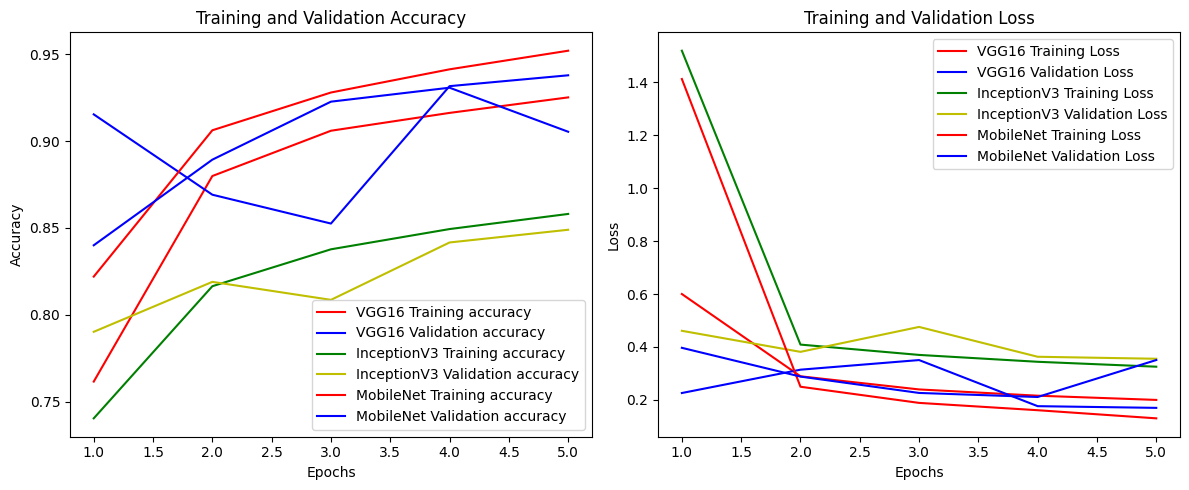

In [54]:
# VGG16
acc_VGG16 = history_VGG16.history['accuracy']
val_acc_VGG16 = history_VGG16.history['val_accuracy']
loss_VGG16 = history_VGG16.history['loss']
val_loss_VGG16 = history_VGG16.history['val_loss']

# InceptionV3
acc_InceptionV3 = history_InceptionV3.history['accuracy']
val_acc_InceptionV3 = history_InceptionV3.history['val_accuracy']
loss_InceptionV3 = history_InceptionV3.history['loss']
val_loss_InceptionV3 = history_InceptionV3.history['val_loss']

# MobileNet
acc_MobileNet = history_MobileNet.history['accuracy']
val_acc_MobileNet = history_MobileNet.history['val_accuracy']
loss_MobileNet = history_MobileNet.history['loss']
val_loss_MobileNet = history_MobileNet.history['val_loss']

epochs = range(1, len(acc_VGG16) + 1)

# Create two subplots, one for accuracy and one for loss
plt.figure(figsize=(12, 5))

# Training and validation accuracy subplot
plt.subplot(1, 2, 1)

plt.plot(epochs, acc_VGG16, 'r', label='VGG16 Training accuracy')
plt.plot(epochs, val_acc_VGG16, 'b', label='VGG16 Validation accuracy')
plt.plot(epochs, acc_InceptionV3, 'g', label='InceptionV3 Training accuracy')
plt.plot(epochs, val_acc_InceptionV3, 'y', label='InceptionV3 Validation accuracy')
plt.plot(epochs, acc_MobileNet, 'r', label='MobileNet Training accuracy')
plt.plot(epochs, val_acc_MobileNet, 'b', label='MobileNet Validation accuracy')
"""
plt.plot(epochs, acc_EfficientNetB7, 'g', label='EfficientNetB7 Training accuracy')
plt.plot(epochs, val_acc_EfficientNetB7, 'y', label='EfficientNetB7 Validation accuracy')
plt.plot(epochs, acc_NASNetMobile, 'r', label='NASNetMobile Training accuracy')
plt.plot(epochs, val_loss_NASNetMobile, 'b', label='NASNetMobile Validation accuracy')
"""
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Training and validation loss subplot
plt.subplot(1, 2, 2)

plt.plot(epochs, loss_VGG16, 'r', label='VGG16 Training Loss')
plt.plot(epochs, val_loss_VGG16, 'b', label='VGG16 Validation Loss')
plt.plot(epochs, loss_InceptionV3, 'g', label='InceptionV3 Training Loss')
plt.plot(epochs, val_loss_InceptionV3, 'y', label='InceptionV3 Validation Loss')
plt.plot(epochs, loss_MobileNet, 'r', label='MobileNet Training Loss')
plt.plot(epochs, val_loss_MobileNet, 'b', label='MobileNet Validation Loss')
"""
plt.plot(epochs, loss_EfficientNetB7, 'g', label='EfficientNetB7 Training Loss')
plt.plot(epochs, val_loss_EfficientNetB7, 'y', label='EfficientNetB7 Validation Loss')
plt.plot(epochs, loss_NASNetMobile, 'r', label='NASNetMobile Training Loss')
plt.plot(epochs, val_loss_NASNetMobile, 'b', label='NASNetMobile Validation Loss')
"""
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluate Learning

In [55]:
def evaluate_model(model, test_data):

    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]

    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))

    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("Classification Report:\n----------------------\n", clr)

#### 1. VGG16

    Test Loss: 0.16443
Test Accuracy: 93.94%
375/375 [==============================] - 173s 462ms/step


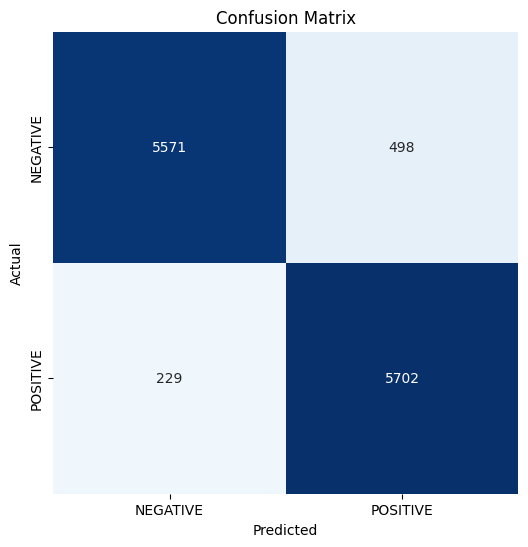

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.96      0.92      0.94      6069
    POSITIVE       0.92      0.96      0.94      5931

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000

Execution time: 342.32858395576477 seconds


In [56]:
start_time = time.time()
evaluate_model(VGG16_model, test_data)
end_time = time.time()
execution_time_VGG16_model = end_time - start_time

print(f"Execution time: {execution_time_VGG16_model} seconds")


#### 2. InceptionV3

    Test Loss: 0.33279
Test Accuracy: 86.39%
375/375 [==============================] - 135s 358ms/step


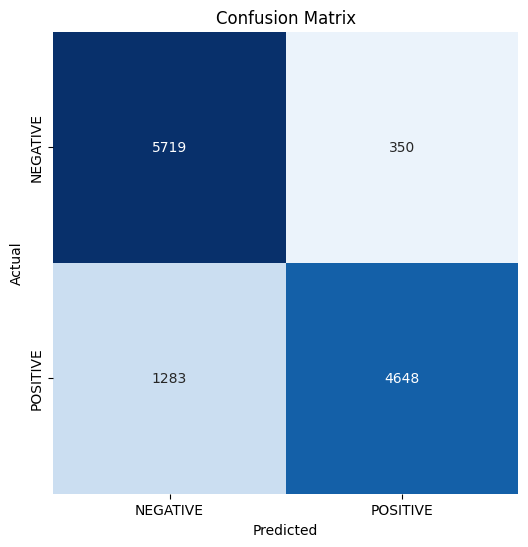

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.82      0.94      0.88      6069
    POSITIVE       0.93      0.78      0.85      5931

    accuracy                           0.86     12000
   macro avg       0.87      0.86      0.86     12000
weighted avg       0.87      0.86      0.86     12000

Execution time: 301.48964166641235 seconds


In [57]:
start_time = time.time()
evaluate_model(InceptionV3_model, test_data)
end_time = time.time()
execution_time_InceptionV3_model = end_time - start_time

print(f"Execution time: {execution_time_InceptionV3_model} seconds")


#### 3. MobileNet

    Test Loss: 0.31157
Test Accuracy: 90.78%
375/375 [==============================] - 125s 330ms/step


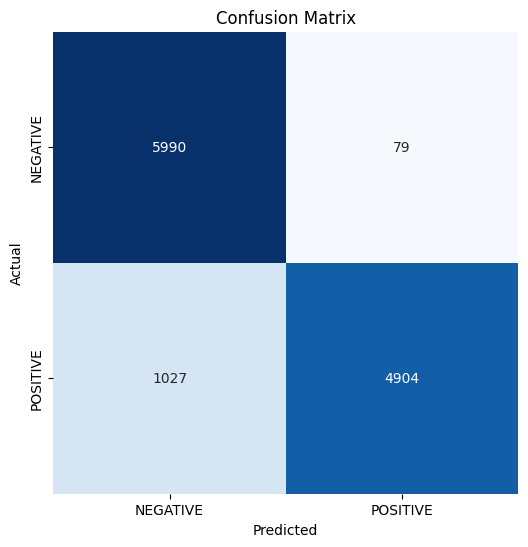

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.85      0.99      0.92      6069
    POSITIVE       0.98      0.83      0.90      5931

    accuracy                           0.91     12000
   macro avg       0.92      0.91      0.91     12000
weighted avg       0.92      0.91      0.91     12000

Execution time: 250.102712392807 seconds


In [58]:
start_time = time.time()
evaluate_model(MobileNet_model, test_data)
end_time = time.time()
execution_time_MobileNet_model = end_time - start_time

print(f"Execution time: {execution_time_MobileNet_model} seconds")


#### 4. EfficientNetB7

In [ ]:
start_time = time.time()
evaluate_model(EfficientNetB7_model, test_data)
end_time = time.time()
execution_time_EfficientNetB7_model = end_time - start_time

print(f"Execution time: {execution_time_EfficientNetB7_model} seconds")


#### 5. NASNetMobile

In [ ]:
start_time = time.time()
evaluate_model(NASNetMobile_model, test_data)
end_time = time.time()
execution_time_NASNetMobile_model = end_time - start_time

print(f"Execution time: {execution_time_NASNetMobile_model} seconds")


# show execution time models

In [59]:
execution_time = {
    "VGG16":execution_time_VGG16_model
   , "InceptionV3":execution_time_InceptionV3_model
   , "MobileNet":execution_time_MobileNet_model

}
df = pd.DataFrame.from_dict(execution_time, orient='index')
print(df)

                      0
VGG16        342.328584
InceptionV3  301.489642
MobileNet    250.102712


In [ ]:
"""
execution_time = {
    "VGG16":execution_time_VGG16_model
   , "InceptionV3":execution_time_InceptionV3_model
   , "MobileNet":execution_time_MobileNet_model
   , "EfficientNetB7":execution_time_EfficientNetB7_model
   , "NASNetMobile":execution_time_NASNetMobile_model
}
df = pd.DataFrame.from_dict(execution_time, orient='index')
print(df)
""

### Save Model

In [61]:
# VGG16
VGG16_model.save('/kaggle/working/Crack_Detection_VGG16_model.keras')

# InceptionV3
InceptionV3_model.save('/kaggle/working/Crack_Detection_InceptionV3_model.keras')

# MobileNet
MobileNet_model.save('/kaggle/working/Crack_Detection_MobileNet_model.keras')
"""
# EfficientNetB7
EfficientNetB7_model.save('/kaggle/working/Crack_Detection_EfficientNetB7_model.keras')

# NASNetMobile
NASNetMobile_model.save('/kaggle/working/Crack_Detection_NASNetMobile_model.keras')
"""

"\n# EfficientNetB7\nEfficientNetB7_model.save('/kaggle/working/Crack_Detection_EfficientNetB7_model.keras')\n\n# NASNetMobile\nNASNetMobile_model.save('/kaggle/working/Crack_Detection_NASNetMobile_model.keras')\n"